In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
random.seed(123)

# directory that contains pickle files
data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'openpose_zeros_all')

# Helper functions

In [3]:
def data_generator(T, C, le):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    X = T['pose'] # list of arrays
    Y = np.zeros(shape=(len(T['label']), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(T['label'])] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [5]:
Train = pickle.load(open(os.path.join(data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

LabelEncoder()

In [6]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=25, joint_dim=2, num_classes=21, num_filters=32)

X, Y = data_generator(Train,C,le)
X_test,Y_test = data_generator(Test,C,le)

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

497 (40, 25, 2) (497, 21)
195 (40, 25, 2) (195, 21)


### Cleaning and transforming OpenPose outputs

In [7]:
cleaner = ddnet.OpenPoseDataCleaner(copy=False)

X_clean, Y_clean = cleaner.augment_XY(X, Y, factor=5)
X_test_clean, Y_test_clean = cleaner.augment_XY(X_test, Y_test, factor=1)

print(len(X_clean), X_clean[0].shape, Y_clean.shape)
print(len(X_test_clean), X_test_clean[0].shape, Y_test_clean.shape)

2485 (40, 15, 2) (2485, 21)
195 (40, 15, 2) (195, 21)


In [8]:
# commit changes
X_input, Y_input = X_clean, Y_clean
X_test_input, Y_test_input = X_test_clean, Y_test_clean

### DDNet's preprocess and config

In [9]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=len(cleaner.filter_joint_idx), joint_dim=2, num_classes=21, num_filters=32)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Building the model

In [10]:
DD_Net = ddnet.create_DDNet(C)
DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 256)       436544      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_ma

# Train, Test and Save/Load the Model

### Train and plot loss/accuracy

In [11]:
import keras
from keras import backend as K
from keras.optimizers import *

# K.set_session(tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=16)))

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input)      
                    )



Train on 2485 samples, validate on 195 samples
Epoch 1/800
2485/2485 [==============================] - 5s 2ms/step - loss: 3.8195 - accuracy: 0.0443 - val_loss: 3.0438 - val_accuracy: 0.0256
Epoch 2/800
2485/2485 [==============================] - 0s 65us/step - loss: 3.5695 - accuracy: 0.0632 - val_loss: 3.0411 - val_accuracy: 0.1026
Epoch 3/800
2485/2485 [==============================] - 0s 60us/step - loss: 3.4091 - accuracy: 0.0704 - val_loss: 3.0386 - val_accuracy: 0.1231
Epoch 4/800
2485/2485 [==============================] - 0s 60us/step - loss: 3.2955 - accuracy: 0.1066 - val_loss: 3.0353 - val_accuracy: 0.0769
Epoch 5/800
2485/2485 [==============================] - 0s 60us/step - loss: 3.2096 - accuracy: 0.1030 - val_loss: 3.0310 - val_accuracy: 0.0872
Epoch 6/800
2485/2485 [==============================] - 0s 64us/step - loss: 3.1126 - accuracy: 0.1352 - val_loss: 3.0262 - val_accuracy: 0.0718
Epoch 7/800
2485/2485 [==============================] - 0s 67us/step - loss:

Epoch 55/800
2485/2485 [==============================] - 0s 65us/step - loss: 1.1224 - accuracy: 0.6410 - val_loss: 2.4874 - val_accuracy: 0.2103
Epoch 56/800
2485/2485 [==============================] - 0s 64us/step - loss: 1.0911 - accuracy: 0.6551 - val_loss: 2.4812 - val_accuracy: 0.2051
Epoch 57/800
2485/2485 [==============================] - 0s 62us/step - loss: 1.0745 - accuracy: 0.6757 - val_loss: 2.4747 - val_accuracy: 0.2154
Epoch 58/800
2485/2485 [==============================] - 0s 64us/step - loss: 1.0417 - accuracy: 0.6732 - val_loss: 2.4635 - val_accuracy: 0.2205
Epoch 59/800
2485/2485 [==============================] - 0s 65us/step - loss: 1.0178 - accuracy: 0.6934 - val_loss: 2.4529 - val_accuracy: 0.2205
Epoch 60/800
2485/2485 [==============================] - 0s 64us/step - loss: 1.0155 - accuracy: 0.6885 - val_loss: 2.4378 - val_accuracy: 0.2256
Epoch 61/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.9960 - accuracy: 0.6938 - val_loss: 2

Epoch 111/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.3527 - accuracy: 0.9002 - val_loss: 2.2704 - val_accuracy: 0.3590
Epoch 112/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.3495 - accuracy: 0.9115 - val_loss: 2.2711 - val_accuracy: 0.3590
Epoch 113/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.3337 - accuracy: 0.9187 - val_loss: 2.2766 - val_accuracy: 0.3590
Epoch 114/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.3421 - accuracy: 0.9074 - val_loss: 2.2754 - val_accuracy: 0.3538
Epoch 115/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.3432 - accuracy: 0.9030 - val_loss: 2.2548 - val_accuracy: 0.3744
Epoch 116/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.3230 - accuracy: 0.9127 - val_loss: 2.2333 - val_accuracy: 0.3795
Epoch 117/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.3163 - accuracy: 0.9199 - val_

Epoch 167/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.1162 - accuracy: 0.9831 - val_loss: 2.2664 - val_accuracy: 0.4513
Epoch 168/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.1178 - accuracy: 0.9767 - val_loss: 2.2491 - val_accuracy: 0.4462
Epoch 169/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.1127 - accuracy: 0.9791 - val_loss: 2.2374 - val_accuracy: 0.4564
Epoch 170/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.1141 - accuracy: 0.9787 - val_loss: 2.2389 - val_accuracy: 0.4667
Epoch 171/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.1240 - accuracy: 0.9734 - val_loss: 2.2386 - val_accuracy: 0.4667
Epoch 172/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.1210 - accuracy: 0.9799 - val_loss: 2.2347 - val_accuracy: 0.4667
Epoch 173/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.1094 - accuracy: 0.9831 - val_

Epoch 223/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0643 - accuracy: 0.9920 - val_loss: 2.3145 - val_accuracy: 0.4667
Epoch 224/800
2485/2485 [==============================] - 0s 57us/step - loss: 0.0649 - accuracy: 0.9891 - val_loss: 2.3186 - val_accuracy: 0.4667
Epoch 225/800
2485/2485 [==============================] - 0s 73us/step - loss: 0.0591 - accuracy: 0.9915 - val_loss: 2.3218 - val_accuracy: 0.4667
Epoch 226/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0655 - accuracy: 0.9911 - val_loss: 2.3236 - val_accuracy: 0.4615
Epoch 227/800
2485/2485 [==============================] - 0s 59us/step - loss: 0.0668 - accuracy: 0.9875 - val_loss: 2.3240 - val_accuracy: 0.4615
Epoch 228/800
2485/2485 [==============================] - 0s 58us/step - loss: 0.0586 - accuracy: 0.9920 - val_loss: 2.3243 - val_accuracy: 0.4718
Epoch 229/800
2485/2485 [==============================] - 0s 58us/step - loss: 0.0664 - accuracy: 0.9883 - val_

Epoch 279/800
2485/2485 [==============================] - 0s 54us/step - loss: 0.0517 - accuracy: 0.9944 - val_loss: 2.2717 - val_accuracy: 0.4974
Epoch 280/800
2485/2485 [==============================] - 0s 57us/step - loss: 0.0605 - accuracy: 0.9911 - val_loss: 2.2699 - val_accuracy: 0.4974
Epoch 281/800
2485/2485 [==============================] - 0s 54us/step - loss: 0.0573 - accuracy: 0.9903 - val_loss: 2.2681 - val_accuracy: 0.4974
Epoch 282/800
2485/2485 [==============================] - 0s 54us/step - loss: 0.0594 - accuracy: 0.9907 - val_loss: 2.2664 - val_accuracy: 0.4974
Epoch 283/800
2485/2485 [==============================] - 0s 53us/step - loss: 0.0607 - accuracy: 0.9907 - val_loss: 2.2648 - val_accuracy: 0.4974
Epoch 284/800
2485/2485 [==============================] - 0s 55us/step - loss: 0.0654 - accuracy: 0.9887 - val_loss: 2.2632 - val_accuracy: 0.5026
Epoch 285/800
2485/2485 [==============================] - 0s 52us/step - loss: 0.0659 - accuracy: 0.9875 - val_

Epoch 335/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0554 - accuracy: 0.9924 - val_loss: 2.1627 - val_accuracy: 0.5385
Epoch 336/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0614 - accuracy: 0.9895 - val_loss: 2.1610 - val_accuracy: 0.5436
Epoch 337/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0632 - accuracy: 0.9899 - val_loss: 2.1591 - val_accuracy: 0.5436
Epoch 338/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0709 - accuracy: 0.9891 - val_loss: 2.1574 - val_accuracy: 0.5436
Epoch 339/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0600 - accuracy: 0.9911 - val_loss: 2.1555 - val_accuracy: 0.5436
Epoch 340/800
2485/2485 [==============================] - 0s 72us/step - loss: 0.0611 - accuracy: 0.9887 - val_loss: 2.1535 - val_accuracy: 0.5436
Epoch 341/800
2485/2485 [==============================] - 0s 70us/step - loss: 0.0641 - accuracy: 0.9903 - val_

Epoch 391/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0636 - accuracy: 0.9875 - val_loss: 2.0673 - val_accuracy: 0.5590
Epoch 392/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0586 - accuracy: 0.9895 - val_loss: 2.0653 - val_accuracy: 0.5590
Epoch 393/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0562 - accuracy: 0.9915 - val_loss: 2.0635 - val_accuracy: 0.5590
Epoch 394/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0665 - accuracy: 0.9847 - val_loss: 2.0618 - val_accuracy: 0.5590
Epoch 395/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0554 - accuracy: 0.9924 - val_loss: 2.0600 - val_accuracy: 0.5590
Epoch 396/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0582 - accuracy: 0.9895 - val_loss: 2.0581 - val_accuracy: 0.5590
Epoch 397/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0586 - accuracy: 0.9907 - val_

Epoch 447/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0509 - accuracy: 0.9936 - val_loss: 1.9788 - val_accuracy: 0.5744
Epoch 448/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0532 - accuracy: 0.9903 - val_loss: 1.9776 - val_accuracy: 0.5744
Epoch 449/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0581 - accuracy: 0.9907 - val_loss: 1.9766 - val_accuracy: 0.5744
Epoch 450/800
2485/2485 [==============================] - 0s 77us/step - loss: 0.0609 - accuracy: 0.9879 - val_loss: 1.9755 - val_accuracy: 0.5692
Epoch 451/800
2485/2485 [==============================] - 0s 71us/step - loss: 0.0579 - accuracy: 0.9911 - val_loss: 1.9745 - val_accuracy: 0.5641
Epoch 452/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0552 - accuracy: 0.9915 - val_loss: 1.9735 - val_accuracy: 0.5641
Epoch 453/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0557 - accuracy: 0.9907 - val_

Epoch 503/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0585 - accuracy: 0.9920 - val_loss: 1.9337 - val_accuracy: 0.5795
Epoch 504/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0598 - accuracy: 0.9915 - val_loss: 1.9331 - val_accuracy: 0.5795
Epoch 505/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0584 - accuracy: 0.9903 - val_loss: 1.9326 - val_accuracy: 0.5795
Epoch 506/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0596 - accuracy: 0.9907 - val_loss: 1.9320 - val_accuracy: 0.5795
Epoch 507/800
2485/2485 [==============================] - 0s 67us/step - loss: 0.0651 - accuracy: 0.9891 - val_loss: 1.9316 - val_accuracy: 0.5795
Epoch 508/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0592 - accuracy: 0.9903 - val_loss: 1.9312 - val_accuracy: 0.5795
Epoch 509/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0497 - accuracy: 0.9940 - val_

Epoch 559/800
2485/2485 [==============================] - 0s 68us/step - loss: 0.0562 - accuracy: 0.9903 - val_loss: 1.9135 - val_accuracy: 0.5949
Epoch 560/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0629 - accuracy: 0.9895 - val_loss: 1.9133 - val_accuracy: 0.5949
Epoch 561/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0622 - accuracy: 0.9907 - val_loss: 1.9130 - val_accuracy: 0.5949
Epoch 562/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0554 - accuracy: 0.9915 - val_loss: 1.9128 - val_accuracy: 0.5949
Epoch 563/800
2485/2485 [==============================] - 0s 66us/step - loss: 0.0545 - accuracy: 0.9899 - val_loss: 1.9124 - val_accuracy: 0.5949
Epoch 564/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0466 - accuracy: 0.9940 - val_loss: 1.9121 - val_accuracy: 0.5949
Epoch 565/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0498 - accuracy: 0.9940 - val_

Epoch 615/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0538 - accuracy: 0.9932 - val_loss: 1.9001 - val_accuracy: 0.5949
Epoch 616/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0580 - accuracy: 0.9899 - val_loss: 1.9001 - val_accuracy: 0.5949
Epoch 617/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0563 - accuracy: 0.9911 - val_loss: 1.9001 - val_accuracy: 0.5949
Epoch 618/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0680 - accuracy: 0.9859 - val_loss: 1.9002 - val_accuracy: 0.5949
Epoch 619/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0458 - accuracy: 0.9968 - val_loss: 1.9002 - val_accuracy: 0.5949
Epoch 620/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0603 - accuracy: 0.9875 - val_loss: 1.9001 - val_accuracy: 0.5949
Epoch 621/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0577 - accuracy: 0.9899 - val_

Epoch 671/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0520 - accuracy: 0.9928 - val_loss: 1.8967 - val_accuracy: 0.5897
Epoch 672/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0582 - accuracy: 0.9891 - val_loss: 1.8965 - val_accuracy: 0.5897
Epoch 673/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0513 - accuracy: 0.9940 - val_loss: 1.8964 - val_accuracy: 0.5897
Epoch 674/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0526 - accuracy: 0.9940 - val_loss: 1.8961 - val_accuracy: 0.5897
Epoch 675/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0520 - accuracy: 0.9895 - val_loss: 1.8959 - val_accuracy: 0.5897
Epoch 676/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0631 - accuracy: 0.9883 - val_loss: 1.8958 - val_accuracy: 0.5897
Epoch 677/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0530 - accuracy: 0.9936 - val_

Epoch 727/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0551 - accuracy: 0.9928 - val_loss: 1.8944 - val_accuracy: 0.5897
Epoch 728/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0540 - accuracy: 0.9924 - val_loss: 1.8944 - val_accuracy: 0.5897
Epoch 729/800
2485/2485 [==============================] - 0s 65us/step - loss: 0.0550 - accuracy: 0.9895 - val_loss: 1.8943 - val_accuracy: 0.5897
Epoch 730/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0575 - accuracy: 0.9915 - val_loss: 1.8942 - val_accuracy: 0.5897
Epoch 731/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0521 - accuracy: 0.9928 - val_loss: 1.8941 - val_accuracy: 0.5897
Epoch 732/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0564 - accuracy: 0.9915 - val_loss: 1.8940 - val_accuracy: 0.5846
Epoch 733/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0542 - accuracy: 0.9907 - val_

Epoch 783/800
2485/2485 [==============================] - 0s 63us/step - loss: 0.0486 - accuracy: 0.9948 - val_loss: 1.8924 - val_accuracy: 0.5795
Epoch 784/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0477 - accuracy: 0.9928 - val_loss: 1.8924 - val_accuracy: 0.5795
Epoch 785/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0600 - accuracy: 0.9887 - val_loss: 1.8924 - val_accuracy: 0.5795
Epoch 786/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0552 - accuracy: 0.9903 - val_loss: 1.8923 - val_accuracy: 0.5795
Epoch 787/800
2485/2485 [==============================] - 0s 64us/step - loss: 0.0531 - accuracy: 0.9915 - val_loss: 1.8922 - val_accuracy: 0.5795
Epoch 788/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0532 - accuracy: 0.9928 - val_loss: 1.8921 - val_accuracy: 0.5795
Epoch 789/800
2485/2485 [==============================] - 0s 62us/step - loss: 0.0618 - accuracy: 0.9883 - val_

Epoch 39/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0466 - accuracy: 0.9948 - val_loss: 1.9096 - val_accuracy: 0.5897
Epoch 40/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0544 - accuracy: 0.9915 - val_loss: 1.9094 - val_accuracy: 0.5897
Epoch 41/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0551 - accuracy: 0.9924 - val_loss: 1.9093 - val_accuracy: 0.5897
Epoch 42/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0512 - accuracy: 0.9924 - val_loss: 1.9092 - val_accuracy: 0.5897
Epoch 43/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0508 - accuracy: 0.9932 - val_loss: 1.9091 - val_accuracy: 0.5897
Epoch 44/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0588 - accuracy: 0.9911 - val_loss: 1.9091 - val_accuracy: 0.5897
Epoch 45/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0465 - accuracy: 0.9932 - val_loss: 1

Epoch 95/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0478 - accuracy: 0.9928 - val_loss: 1.9105 - val_accuracy: 0.5846
Epoch 96/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0512 - accuracy: 0.9915 - val_loss: 1.9106 - val_accuracy: 0.5846
Epoch 97/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0499 - accuracy: 0.9924 - val_loss: 1.9106 - val_accuracy: 0.5846
Epoch 98/600
2485/2485 [==============================] - 0s 67us/step - loss: 0.0436 - accuracy: 0.9948 - val_loss: 1.9106 - val_accuracy: 0.5846
Epoch 99/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0518 - accuracy: 0.9895 - val_loss: 1.9107 - val_accuracy: 0.5846
Epoch 100/600
2485/2485 [==============================] - 0s 67us/step - loss: 0.0548 - accuracy: 0.9911 - val_loss: 1.9108 - val_accuracy: 0.5846
Epoch 101/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0442 - accuracy: 0.9952 - val_loss:

Epoch 151/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0492 - accuracy: 0.9907 - val_loss: 1.9144 - val_accuracy: 0.5846
Epoch 152/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0546 - accuracy: 0.9911 - val_loss: 1.9146 - val_accuracy: 0.5846
Epoch 153/600
2485/2485 [==============================] - 0s 71us/step - loss: 0.0561 - accuracy: 0.9891 - val_loss: 1.9147 - val_accuracy: 0.5846
Epoch 154/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0579 - accuracy: 0.9883 - val_loss: 1.9147 - val_accuracy: 0.5846
Epoch 155/600
2485/2485 [==============================] - 0s 67us/step - loss: 0.0519 - accuracy: 0.9924 - val_loss: 1.9147 - val_accuracy: 0.5846
Epoch 156/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0436 - accuracy: 0.9944 - val_loss: 1.9146 - val_accuracy: 0.5846
Epoch 157/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0449 - accuracy: 0.9944 - val_

Epoch 207/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0473 - accuracy: 0.9940 - val_loss: 1.9180 - val_accuracy: 0.5846
Epoch 208/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0500 - accuracy: 0.9932 - val_loss: 1.9179 - val_accuracy: 0.5846
Epoch 209/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0505 - accuracy: 0.9928 - val_loss: 1.9178 - val_accuracy: 0.5846
Epoch 210/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0478 - accuracy: 0.9944 - val_loss: 1.9176 - val_accuracy: 0.5846
Epoch 211/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0486 - accuracy: 0.9940 - val_loss: 1.9176 - val_accuracy: 0.5846
Epoch 212/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0465 - accuracy: 0.9932 - val_loss: 1.9175 - val_accuracy: 0.5846
Epoch 213/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0498 - accuracy: 0.9932 - val_

Epoch 263/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0465 - accuracy: 0.9936 - val_loss: 1.9149 - val_accuracy: 0.5795
Epoch 264/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0447 - accuracy: 0.9932 - val_loss: 1.9150 - val_accuracy: 0.5795
Epoch 265/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0544 - accuracy: 0.9911 - val_loss: 1.9150 - val_accuracy: 0.5795
Epoch 266/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0514 - accuracy: 0.9907 - val_loss: 1.9151 - val_accuracy: 0.5795
Epoch 267/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0448 - accuracy: 0.9948 - val_loss: 1.9151 - val_accuracy: 0.5795
Epoch 268/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0458 - accuracy: 0.9928 - val_loss: 1.9151 - val_accuracy: 0.5795
Epoch 269/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0412 - accuracy: 0.9956 - val_

Epoch 319/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0456 - accuracy: 0.9948 - val_loss: 1.9226 - val_accuracy: 0.5846
Epoch 320/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0445 - accuracy: 0.9964 - val_loss: 1.9229 - val_accuracy: 0.5846
Epoch 321/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0502 - accuracy: 0.9920 - val_loss: 1.9233 - val_accuracy: 0.5846
Epoch 322/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0498 - accuracy: 0.9940 - val_loss: 1.9238 - val_accuracy: 0.5846
Epoch 323/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0442 - accuracy: 0.9956 - val_loss: 1.9241 - val_accuracy: 0.5846
Epoch 324/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0433 - accuracy: 0.9956 - val_loss: 1.9245 - val_accuracy: 0.5846
Epoch 325/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0455 - accuracy: 0.9920 - val_

Epoch 375/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0492 - accuracy: 0.9928 - val_loss: 1.9302 - val_accuracy: 0.5846
Epoch 376/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0444 - accuracy: 0.9924 - val_loss: 1.9300 - val_accuracy: 0.5846
Epoch 377/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0509 - accuracy: 0.9920 - val_loss: 1.9298 - val_accuracy: 0.5846
Epoch 378/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0496 - accuracy: 0.9920 - val_loss: 1.9296 - val_accuracy: 0.5795
Epoch 379/600
2485/2485 [==============================] - 0s 68us/step - loss: 0.0495 - accuracy: 0.9932 - val_loss: 1.9294 - val_accuracy: 0.5795
Epoch 380/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0437 - accuracy: 0.9948 - val_loss: 1.9294 - val_accuracy: 0.5795
Epoch 381/600
2485/2485 [==============================] - 0s 70us/step - loss: 0.0500 - accuracy: 0.9915 - val_

Epoch 431/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0474 - accuracy: 0.9928 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 432/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0399 - accuracy: 0.9960 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 433/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0527 - accuracy: 0.9899 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 434/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0454 - accuracy: 0.9936 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 435/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0429 - accuracy: 0.9936 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 436/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0485 - accuracy: 0.9936 - val_loss: 1.9328 - val_accuracy: 0.5795
Epoch 437/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0492 - accuracy: 0.9915 - val_

Epoch 487/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0479 - accuracy: 0.9915 - val_loss: 1.9306 - val_accuracy: 0.5795
Epoch 488/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0432 - accuracy: 0.9932 - val_loss: 1.9304 - val_accuracy: 0.5795
Epoch 489/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0487 - accuracy: 0.9899 - val_loss: 1.9302 - val_accuracy: 0.5795
Epoch 490/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0508 - accuracy: 0.9928 - val_loss: 1.9300 - val_accuracy: 0.5795
Epoch 491/600
2485/2485 [==============================] - 0s 65us/step - loss: 0.0467 - accuracy: 0.9920 - val_loss: 1.9299 - val_accuracy: 0.5795
Epoch 492/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0502 - accuracy: 0.9911 - val_loss: 1.9298 - val_accuracy: 0.5795
Epoch 493/600
2485/2485 [==============================] - 0s 69us/step - loss: 0.0439 - accuracy: 0.9924 - val_

Epoch 543/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0458 - accuracy: 0.9952 - val_loss: 1.9296 - val_accuracy: 0.5795
Epoch 544/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0508 - accuracy: 0.9924 - val_loss: 1.9295 - val_accuracy: 0.5795
Epoch 545/600
2485/2485 [==============================] - 0s 66us/step - loss: 0.0447 - accuracy: 0.9948 - val_loss: 1.9294 - val_accuracy: 0.5795
Epoch 546/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0445 - accuracy: 0.9952 - val_loss: 1.9293 - val_accuracy: 0.5795
Epoch 547/600
2485/2485 [==============================] - 0s 63us/step - loss: 0.0492 - accuracy: 0.9928 - val_loss: 1.9293 - val_accuracy: 0.5795
Epoch 548/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0462 - accuracy: 0.9944 - val_loss: 1.9293 - val_accuracy: 0.5795
Epoch 549/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0436 - accuracy: 0.9932 - val_

Epoch 599/600
2485/2485 [==============================] - 0s 64us/step - loss: 0.0434 - accuracy: 0.9928 - val_loss: 1.9353 - val_accuracy: 0.5795
Epoch 600/600
2485/2485 [==============================] - 0s 62us/step - loss: 0.0475 - accuracy: 0.9924 - val_loss: 1.9355 - val_accuracy: 0.5795


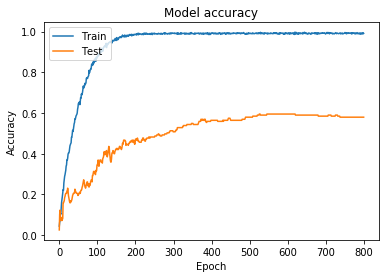

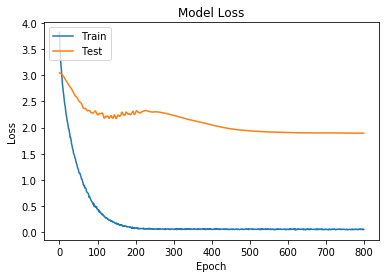

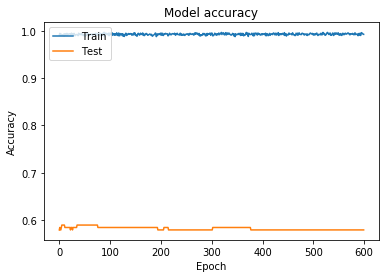

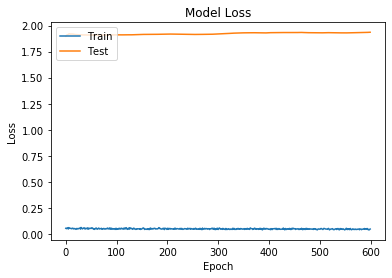

In [12]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [13]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

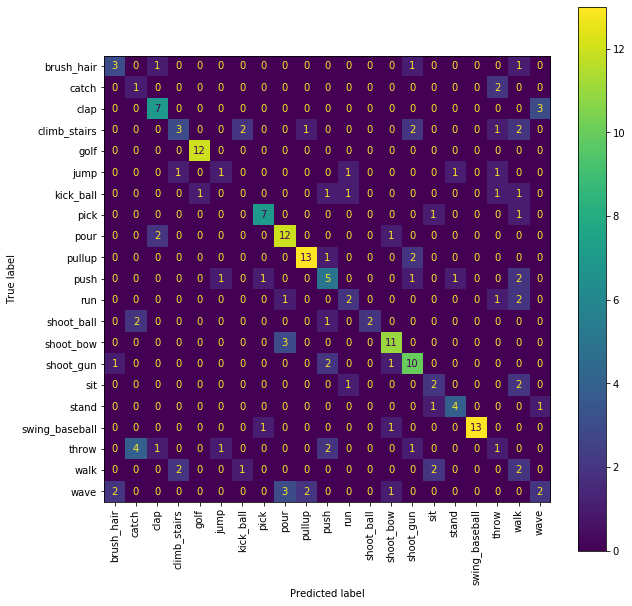

In [14]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
# print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save/Load Model

In [26]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

['brush_hair',
 'catch',
 'clap',
 'climb_stairs',
 'golf',
 'jump',
 'kick_ball',
 'pick',
 'pour',
 'pullup',
 'push',
 'run',
 'shoot_ball',
 'shoot_bow',
 'shoot_gun',
 'sit',
 'stand',
 'swing_baseball',
 'throw',
 'walk',
 'wave']

In [15]:
model_path = 'jhmdb_openpose_model.h5'
ddnet.save_DDNet(DD_Net, model_path)

In [20]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)

195/195 [==============================] - 1s 6ms/step


[1.935507417947818, 0.5794872045516968]

In [24]:
pred1 = new_net.predict([X_test_0[:1], X_test_1[:1]])
print(pred1)
cls_id = np.argmax(pred1)
print(cls_id)
print("Label: ", le.inverse_transform([cls_id]))

[[3.29079398e-06 7.96066888e-05 2.93867629e-06 3.64661755e-05
  2.43893901e-05 1.02552796e-04 1.99075846e-04 2.30071328e-05
  1.75305995e-05 1.21521853e-05 9.96647060e-01 1.39590497e-06
  2.60189205e-04 9.57209093e-04 5.76994440e-04 3.15218017e-06
  8.97112204e-06 9.37285193e-04 4.81069874e-05 4.88601836e-05
  9.67109281e-06]]
10
Label:  ['push']


In [6]:
import json
import requests
import numpy as np

arr = np.random.random((32, 25, 2)) # 32 frames, 25 joints, 2 dimensional
r = requests.post('http://localhost:5000', json=arr.tolist())
assert r.ok
result = r.json()
print(json.dumps(result, indent=2))
print("Predicted class: ", result['labels'][np.argmax(result['scores'])])

{
  "labels": [
    "brush_hair",
    "catch",
    "clap",
    "climb_stairs",
    "golf",
    "jump",
    "kick_ball",
    "pick",
    "pour",
    "pullup",
    "push",
    "run",
    "shoot_ball",
    "shoot_bow",
    "shoot_gun",
    "sit",
    "stand",
    "swing_baseball",
    "throw",
    "walk",
    "wave"
  ],
  "scores": [
    0.0006229308201000094,
    0.007915230467915535,
    0.003072624560445547,
    0.0016112287994474173,
    0.0002581913722679019,
    0.00046603736700490117,
    0.04082413762807846,
    0.0020847092382609844,
    0.0009628880070522428,
    0.0008457086514681578,
    0.009447419084608555,
    0.00019313680240884423,
    0.0022667914163321257,
    0.003423652146011591,
    0.8259473443031311,
    0.0007652117637917399,
    5.399879955803044e-05,
    0.0005272495909593999,
    0.0032544785644859076,
    0.0013300393475219607,
    0.09412696212530136
  ]
}
Predicted class:  shoot_gun
